# Recolorizacion de imagenes de rostros empleando autoencoders
### V1.0 64x64

Caga de los primeros modulos necesarios

In [3]:
import cv2
import pandas as pd
import tarfile
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile

Preparacion de la carpeta donde se van a descargar los datos

In [4]:
path="../Data"

if os.path.isdir(path):
  print("Ya existe el directorio")
else:
  os.mkdir(path)

Descarga de los datos binarios del servidor

In [5]:
!wget -O ../Data/lfw_attributes.txt http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget -O ../Data/lfw-deepfunneled.tgz http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget -O ../Data/lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-05-11 23:49:38--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-05-11 23:49:38--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘../Data/lfw_attributes.txt’

../Data/lfw_attribu 100%[===================>]  14.19M  18.5MB/s    in 0.8s    

2021-05-11 23:49:39 (18.5 MB/s) - ‘../Data/lfw_attributes.txt’ saved [14879205/14879205]

--2021-05-11 23:49:39--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-

Funciones necesarias para el procesado de los datos

In [6]:
ATTRS_NAME = "../Data/lfw_attributes.txt"
IMAGES_NAME = "../Data/lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "../Data/lfw.tgz"

In [7]:
## Función  para decodificar las imágenes bajadas desde datos crudos (bytes)
def decode_image_from_raw_bytes(raw_bytes):
    # Decodificar desde archivos crudos en formato adecuado, flag =1 significa leer en BGR
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    #Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

### Función para bajar las imagenes del .tgz y preprocesarlas sistemáticamente
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Leer archivo lfw_attributes.txt y hacer una limpieza inicial
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    # Corrimiento de carácteres incorrectos
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    # Filtrar nombres de personas y numeros de imagen (por persona), convertir a conjunto
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Leer Fotos e identificación
    all_photos = []
    photo_ids = []

    # Abrir archivo .tgz sin descomprimir
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        # tqdm se usa para mostrar la barra de progreso
        for m in tqdm(f.getmembers()):
            # Solo procesa los archivos desde el archivo comprimido que sean realmente imágenes (.jpg)
            if m.isfile() and m.name.endswith(".jpg"):
                # Descomprimir archivo desde el comprimido y convertir a RGB
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Recortar lo que sean caras y cambiar tamaño
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Obtener nombre de la persona y agregarlo a la colección de datos
                fname = os.path.split(m.name)[-1]
                # La razón de -4 es para quitar la extensión .jpg
                fname_splitted = fname[:-4].replace('_', ' ').split()
                # Sacar la identificación del nombre
                person_id = ' '.join(fname_splitted[:-1])
                # Sacar el número de foto por separado
                photo_number = int(fname_splitted[-1])
                # Comparar los metadatos con las fotos reales (DEBEN COINCIDIR)
                if (person_id, photo_number) in imgs_with_attrs:
                    # Cuando coinciden, agregar las fotos
                    all_photos.append(img)
                    # Y también agregar la identidad de las personas
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
                    
    # Hacer un dataframe con los resultados
    photo_ids = pd.DataFrame(photo_ids)
    # UNir las imágenes en un tensor 4D
    all_photos = np.stack(all_photos).astype('uint8')

    # Preservar el orden de encontrados en búsqueda
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs, photo_ids

Preprocesado de los datos, se empleara una resolucion de 64px x 64px

In [8]:
# Obtener el conjunto de datos sin descomprimir
dim_x=64
dim_y=64
X, attr,names = load_lfw_dataset(use_raw=True, dimx=dim_x, dimy=dim_y)

In [9]:
X.shape

(13143, 64, 64, 3)

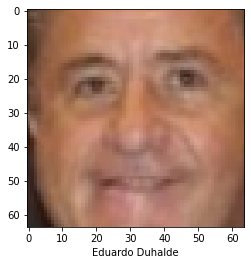

In [10]:
azar=np.random.randint(len(X))

plt.imshow(X[azar])
plt.xlabel(names.person[azar])
plt.show()

Creacion de los datos a blanco y negro a partir de las imagenes a color obtenidas del dataset

In [11]:
X_BW = X @ [0.299, 0.587, 0.114]
X_BW = np.expand_dims(X_BW , axis=3)

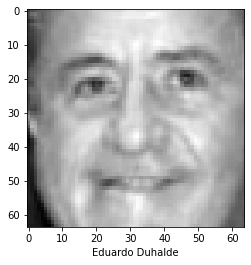

In [12]:
plt.imshow(X_BW[azar][:,:,0], cmap='gray')
plt.xlabel(names.person[azar])
plt.show()

In [ ]:
X.shape

(13143, 64, 64, 3)

In [ ]:
X_BW.shape

(13143, 64, 64, 1)

## Entrenamiento de las redes neuronales para recolorizar las imagenes

Importacion de los modulos necesarios

In [13]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape 
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split

Normalizado de los datos

In [14]:
Input_Data = X_BW.astype('float32') / 255.
Output_Data = X.astype('float32') / 255.

Separacion en datos de entrenamiento y prueba

In [15]:
X_train,X_test=train_test_split(Input_Data,test_size=0.1, random_state=0)
Y_train,Y_test=train_test_split(Output_Data,test_size=0.1, random_state=0)

In [16]:
print('Datos de entrenamiento: ' + str(X_train.shape[0]))
print('Datos de prueba: ' + str(X_test.shape[0]))

Datos de entrenamiento: 11828
Datos de prueba: 1315


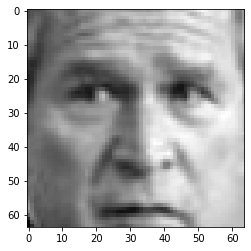

In [17]:
plt.imshow(X_train[100][:,:,0], cmap='gray')

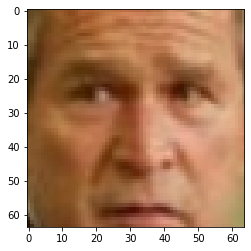

In [18]:
plt.imshow(Y_train[100])

# Modelo MK01

Parametros

In [ ]:
# Train parameters
epochs = 32
batch_size = 256
kernel_size = 3


#Encoder
input_shape = X_train.shape[1:] # (ancho, alto, canales)
layer_filters_encoder = [64, 128, 256, 512]
latent_dim = 512

#Decoder
channels = Y_train.shape[3]
layer_filters_decoder = layer_filters_encoder[::-1]



Encoder

In [ ]:
inputs = Input(shape = input_shape) 
encoder_layers = inputs 
for filters in layer_filters_encoder: 
    encoder_layers = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 2, 
               activation ='relu', 
               padding ='same')(encoder_layers) 

# Save the shape to the decoder
shape = encoder_layers.shape.as_list()

encoder_layers = Flatten()(encoder_layers) 
latent = Dense(latent_dim, name ='latent_vector')(encoder_layers) 
encoder_colorizing = Model(inputs, latent, name ='encoder_colorizing')

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)         1180160   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 512)        

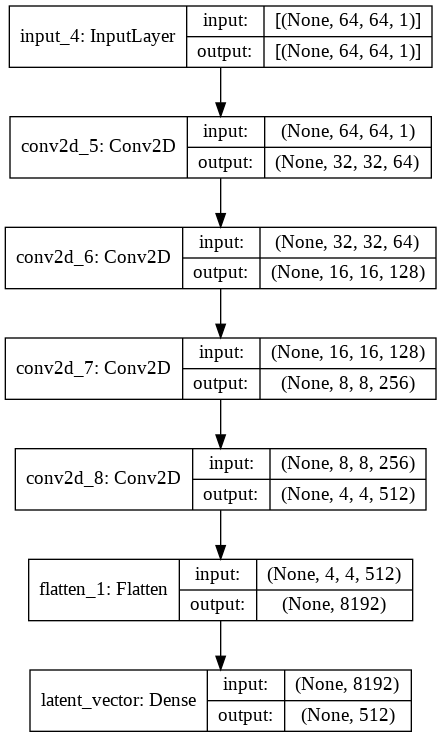

In [ ]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

Decoder

In [ ]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input') 
decoder_layers = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
decoder_layers = Reshape((shape[1], shape[2], shape[3]))(decoder_layers) 

# stack of Conv2DTranspose

for filters in layer_filters_decoder[::-1]: 
    decoder_layers = Conv2DTranspose(filters = filters, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

outputs = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(decoder_layers)
decoder_colorizing = Model(latent_inputs, outputs, name ='decoder_colorizing')

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              4202496   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          294976    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 512)

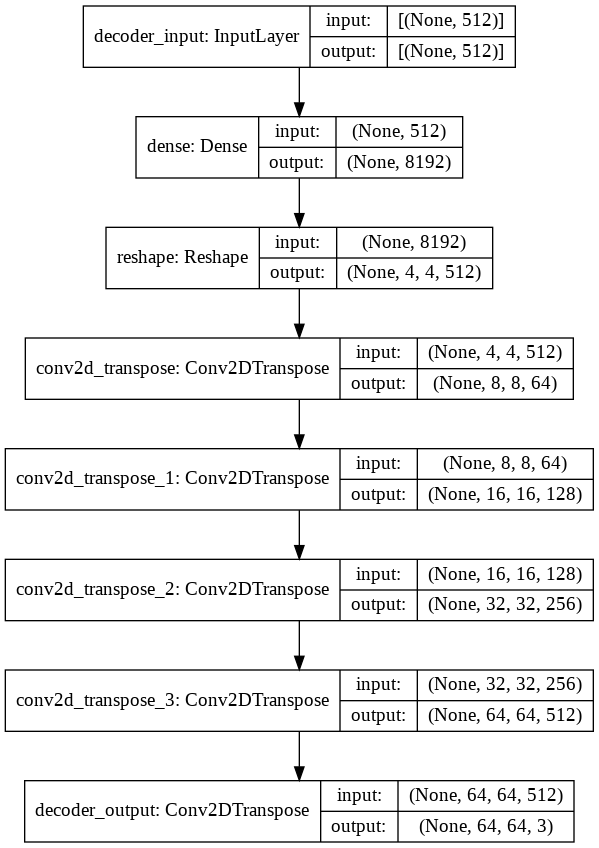

In [ ]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Autoencoder

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing')

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 512)               5744640   
_________________________________________________________________
decoder_colorizing (Function (None, 64, 64, 3)         6060483   
Total params: 11,805,123
Trainable params: 11,805,123
Non-trainable params: 0
_________________________________________________________________


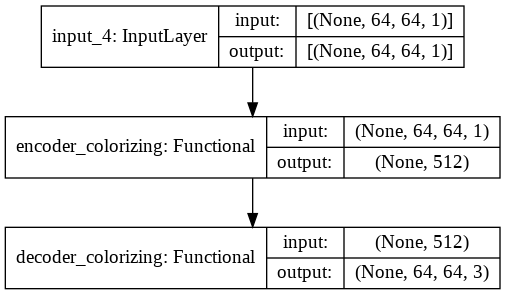

In [ ]:
autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

### Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model_mk1.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

In [ ]:
history=autoencoder_colorizing.fit(X_train,
                Y_train,
                validation_data=(X_test, Y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/32
47/47 [==============================] - 85s 950ms/step - loss: 0.0395 - mae: 0.1607 - val_loss: 0.0352 - val_mae: 0.1508

Epoch 00001: val_loss improved from inf to 0.03523, saving model to /content/saved_models/colorized_ae_model_mk1.001.h5
Epoch 2/32
47/47 [==============================] - 41s 881ms/step - loss: 0.0348 - mae: 0.1498 - val_loss: 0.0312 - val_mae: 0.1413

Epoch 00002: val_loss improved from 0.03523 to 0.03122, saving model to /content/saved_models/colorized_ae_model_mk1.002.h5
Epoch 3/32
47/47 [==============================] - 42s 897ms/step - loss: 0.0296 - mae: 0.1364 - val_loss: 0.0201 - val_mae: 0.1082

Epoch 00003: val_loss improved from 0.03122 to 0.02006, saving model to /content/saved_models/colorized_ae_model_mk1.003.h5
Epoch 4/32
47/47 [==============================] - 42s 897ms/step - loss: 0.0180 - mae: 0.1019 - val_loss: 0.0136 - val_mae: 0.0876

Epoch 00004: val_loss improved from 0.02006 to 0.01362, saving model to /content/saved_models/co

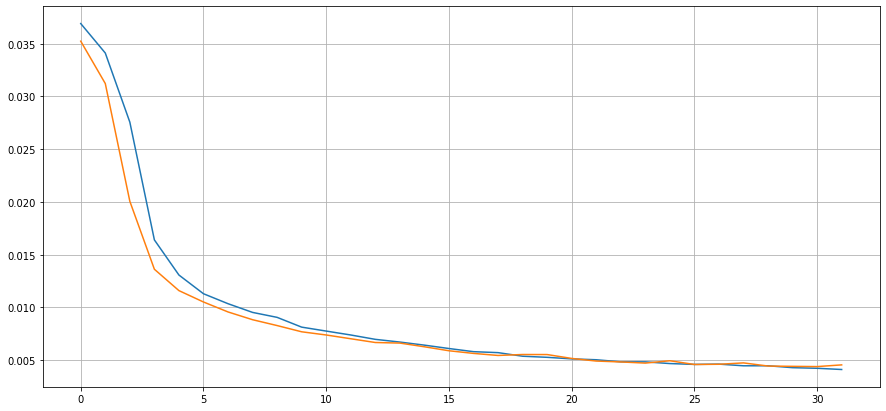

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

### Prueba del modelo

In [ ]:
Y_test_colorized = autoencoder_colorizing.predict(X_test)

In [ ]:
number_of_images = 30

Imagenes a blanco y negro

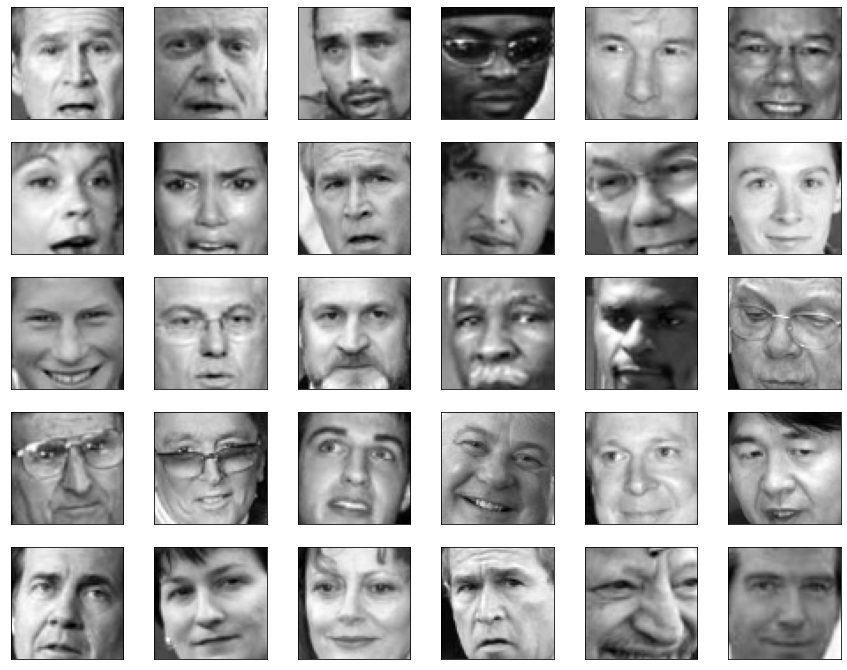

In [ ]:
images = X_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i][:,:,0], cmap='gray')

plt.show()

Imagenes a color originales

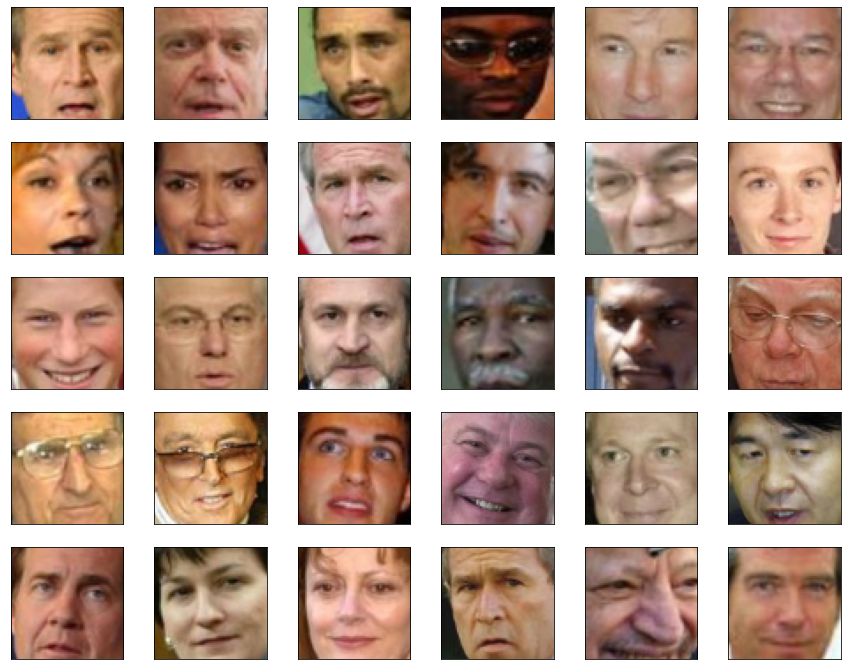

In [ ]:
images = Y_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

Iamgenes colorizadas por la red neuronal

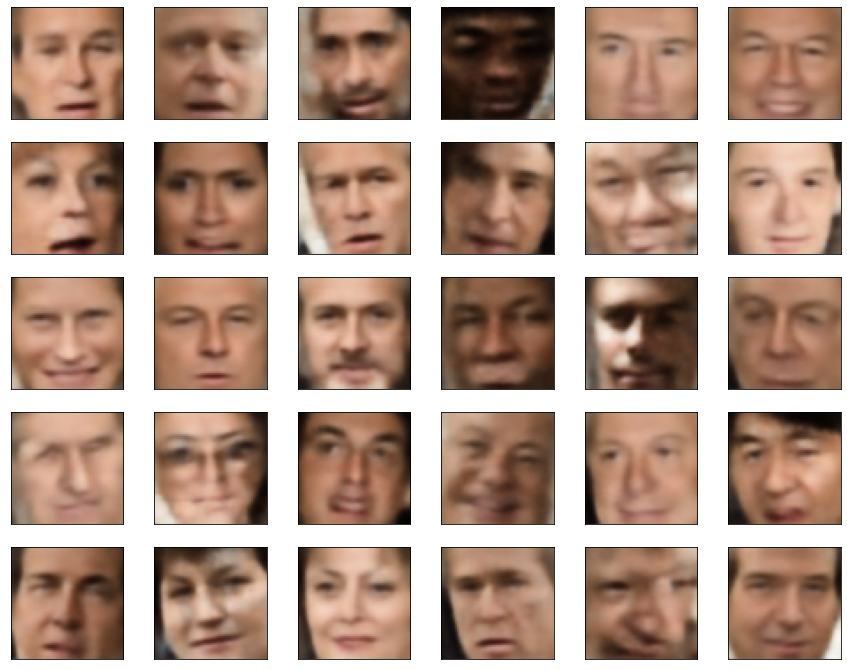

In [ ]:
images = Y_test_colorized

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

# Modelo MK02

Menos parametros, mas ligero

In [ ]:
# Train parameters
epochs = 32
batch_size = 256
kernel_size = 3

Encoder

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 256)         295168    
Total params: 387,840
Trainable params: 387,840
Non-trainable params: 0
_________________________________________________________________


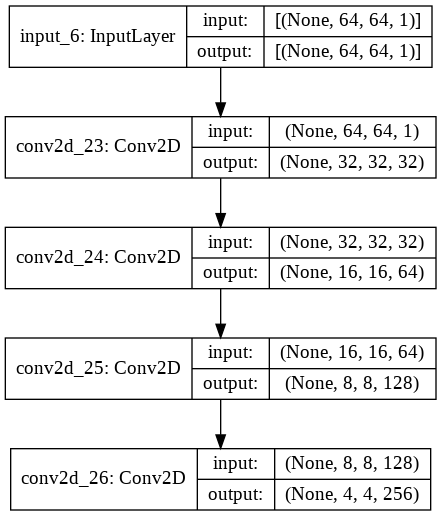

In [ ]:
#Encoder
input_shape = X_train.shape[1:] # (ancho, alto, canales)
layer_filters_encoder = [32, 64, 128, 256]

inputs = Input(shape = input_shape) 
encoder_layers = inputs 
for filters in layer_filters_encoder: 
    encoder_layers = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 2, 
               activation ='relu', 
               padding ='same')(encoder_layers) 

encoder_colorizing = Model(inputs, encoder_layers, name ='encoder_colorizing')

encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

Decoder

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 4, 4, 256)]       0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 128)         295040    
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 64, 64, 16)        4624      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 64, 64, 3)         435       
Total params: 392,355
Trainable params: 392,355
Non-trainable params: 0
__________________________________________

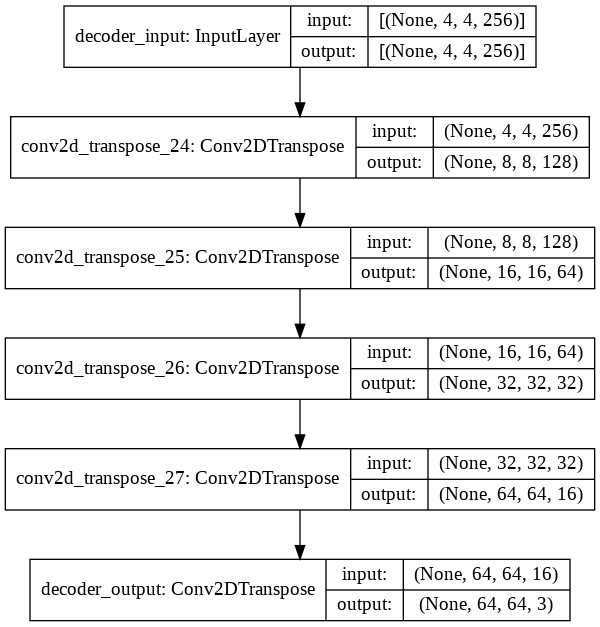

In [ ]:
#Decoder
channels = Y_train.shape[3]
layer_filters_decoder = [128, 64, 32]

input_decoder = Input(shape =(4,4,256), name ='decoder_input') 

decoder_layers = Conv2DTranspose(filters = 128, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(input_decoder) 

decoder_layers = Conv2DTranspose(filters = 64, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = 32, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = 16, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 


decoder_layers = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(decoder_layers)

decoder_colorizing = Model(input_decoder, decoder_layers, name ='decoder_colorizing')

decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Autoencoder

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 4, 4, 256)         387840    
_________________________________________________________________
decoder_colorizing (Function (None, 64, 64, 3)         392355    
Total params: 780,195
Trainable params: 780,195
Non-trainable params: 0
_________________________________________________________________


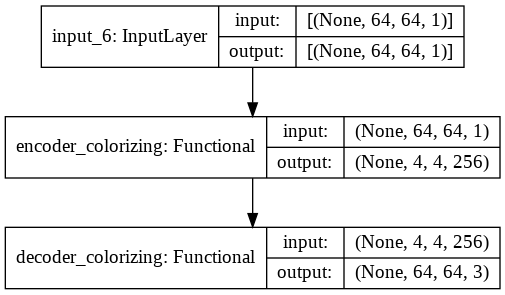

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing')

autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model_mk2.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

In [ ]:
history=autoencoder_colorizing.fit(X_train,
                Y_train,
                validation_data=(X_test, Y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/32
47/47 [==============================] - 5s 83ms/step - loss: 0.0413 - mae: 0.1649 - val_loss: 0.0334 - val_mae: 0.1448

Epoch 00001: val_loss improved from inf to 0.03338, saving model to /content/saved_models/colorized_ae_model_mk2.001.h5
Epoch 2/32
47/47 [==============================] - 3s 70ms/step - loss: 0.0275 - mae: 0.1283 - val_loss: 0.0107 - val_mae: 0.0773

Epoch 00002: val_loss improved from 0.03338 to 0.01074, saving model to /content/saved_models/colorized_ae_model_mk2.002.h5
Epoch 3/32
47/47 [==============================] - 3s 70ms/step - loss: 0.0102 - mae: 0.0757 - val_loss: 0.0082 - val_mae: 0.0667

Epoch 00003: val_loss improved from 0.01074 to 0.00817, saving model to /content/saved_models/colorized_ae_model_mk2.003.h5
Epoch 4/32
47/47 [==============================] - 3s 71ms/step - loss: 0.0080 - mae: 0.0660 - val_loss: 0.0064 - val_mae: 0.0588

Epoch 00004: val_loss improved from 0.00817 to 0.00641, saving model to /content/saved_models/colorized_

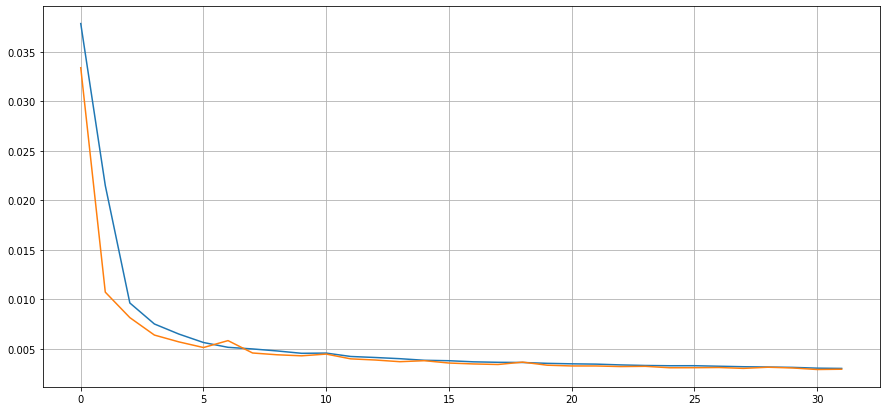

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

### Prueba del modelo

In [ ]:
Y_test_colorized = autoencoder_colorizing.predict(X_test)

In [ ]:
number_of_images = 30

Iamgenes a blanco y negro

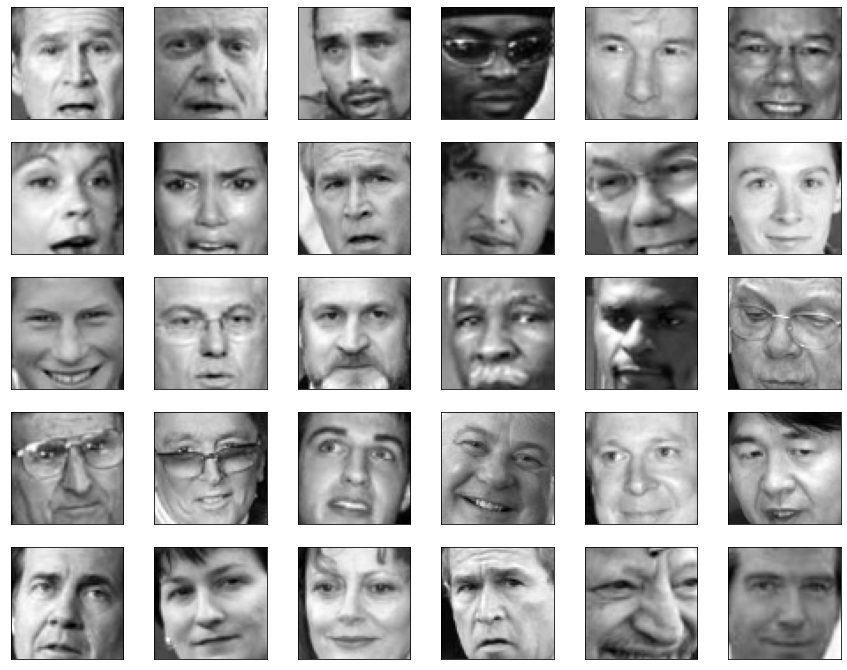

In [ ]:
images = X_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i][:,:,0], cmap='gray')

plt.show()

Iamgenes a color originales

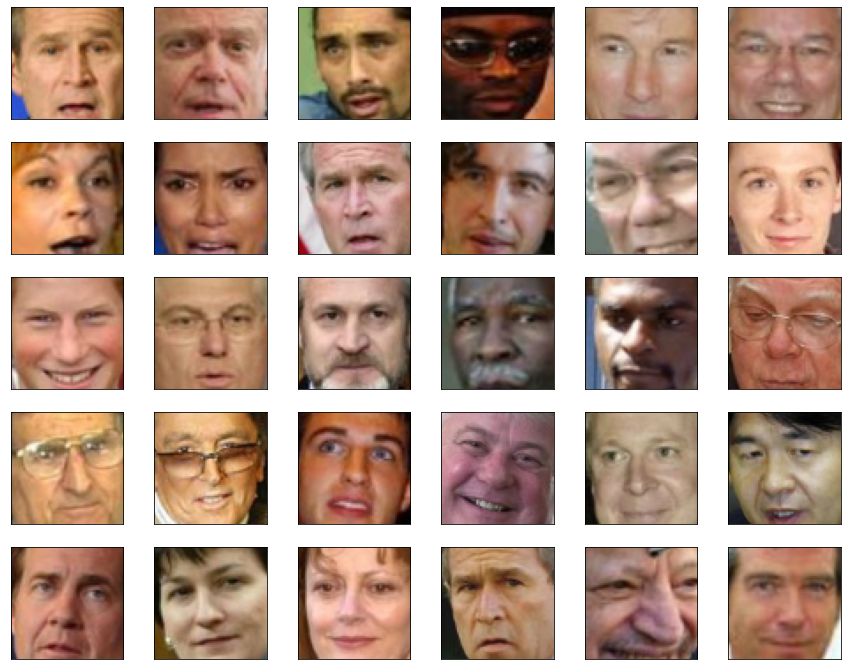

In [ ]:
images = Y_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

Imagenes recolorizadas

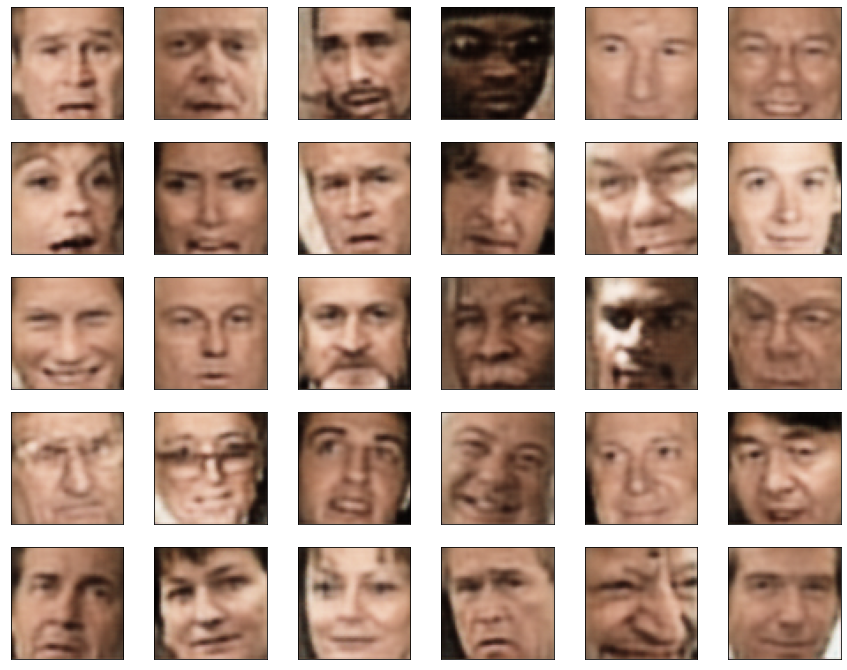

In [ ]:
images = Y_test_colorized

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

# MK02.1

Variaciones al modelo MK02, kernel mas grande

In [ ]:
# Train parameters
epochs = 32
batch_size = 256
kernel_size = 4

Encoder

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 32)        544       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 256)       524544    
Total params: 689,120
Trainable params: 689,120
Non-trainable params: 0
_________________________________________________________________


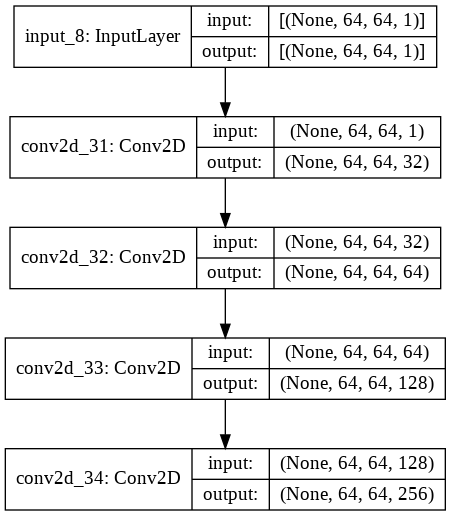

In [ ]:
#Encoder
input_shape = X_train.shape[1:] # (ancho, alto, canales)
layer_filters_encoder = [32, 64, 128, 256]

inputs = Input(shape = input_shape) 

encoder_layers = inputs 

for filters in layer_filters_encoder: 
    encoder_layers = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 1, 
               activation ='relu', 
               padding ='same')(encoder_layers) 

encoder_colorizing = Model(inputs, encoder_layers, name ='encoder_colorizing')

encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

Decoder

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 64, 64, 256)]     0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 64, 64, 128)       524416    
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 64, 64, 64)        131136    
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 64, 64, 32)        32800     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 64, 64, 3)         1539      
Total params: 689,891
Trainable params: 689,891
Non-trainable params: 0
_________________________________________________________________


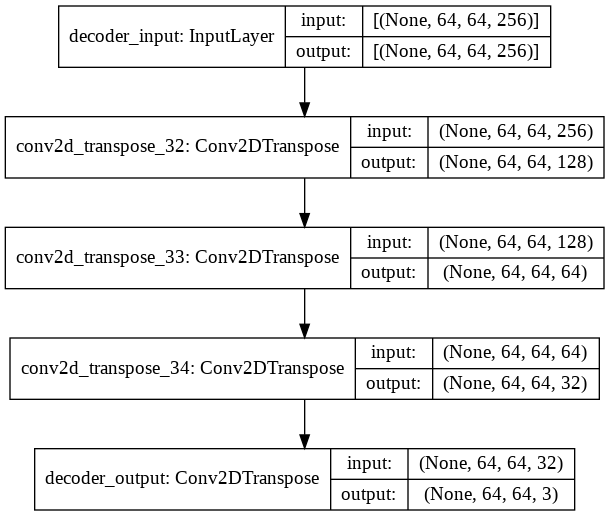

In [ ]:
#Decoder
channels = Y_train.shape[3]
layer_filters_decoder = [128, 64, 32]

input_decoder = Input(shape =(64,64,256), name ='decoder_input') 
decoder_layers =  input_decoder


decoder_layers = Conv2DTranspose(filters = 128, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(input_decoder) 

decoder_layers = Conv2DTranspose(filters = 64, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = 32, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 


decoder_layers = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(decoder_layers)

decoder_colorizing = Model(input_decoder, decoder_layers, name ='decoder_colorizing')

decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Autoencoder

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 64, 64, 256)       689120    
_________________________________________________________________
decoder_colorizing (Function (None, 64, 64, 3)         689891    
Total params: 1,379,011
Trainable params: 1,379,011
Non-trainable params: 0
_________________________________________________________________


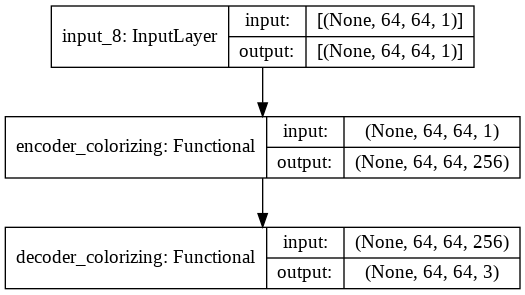

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing')

autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model_mk2_1.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

history=autoencoder_colorizing.fit(X_train,
                Y_train,
                validation_data=(X_test, Y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/32
47/47 [==============================] - 88s 2s/step - loss: 0.0359 - mae: 0.1506 - val_loss: 0.0068 - val_mae: 0.0592

Epoch 00001: val_loss improved from inf to 0.00676, saving model to /content/saved_models/colorized_ae_model_mk2_1.001.h5
Epoch 2/32
47/47 [==============================] - 73s 2s/step - loss: 0.0064 - mae: 0.0588 - val_loss: 0.0047 - val_mae: 0.0515

Epoch 00002: val_loss improved from 0.00676 to 0.00465, saving model to /content/saved_models/colorized_ae_model_mk2_1.002.h5
Epoch 3/32
47/47 [==============================] - 74s 2s/step - loss: 0.0038 - mae: 0.0454 - val_loss: 0.0039 - val_mae: 0.0474

Epoch 00003: val_loss improved from 0.00465 to 0.00385, saving model to /content/saved_models/colorized_ae_model_mk2_1.003.h5
Epoch 4/32
47/47 [==============================] - 75s 2s/step - loss: 0.0032 - mae: 0.0414 - val_loss: 0.0027 - val_mae: 0.0373

Epoch 00004: val_loss improved from 0.00385 to 0.00266, saving model to /content/saved_models/colorize

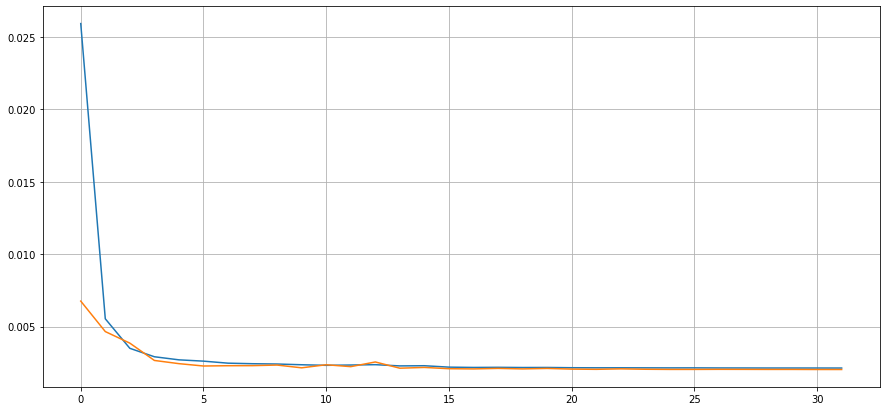

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()


### Prueba del modelo

In [ ]:
Y_test_colorized = autoencoder_colorizing.predict(X_test)

In [ ]:
number_of_images = 30

Iamgens a blanco y negro

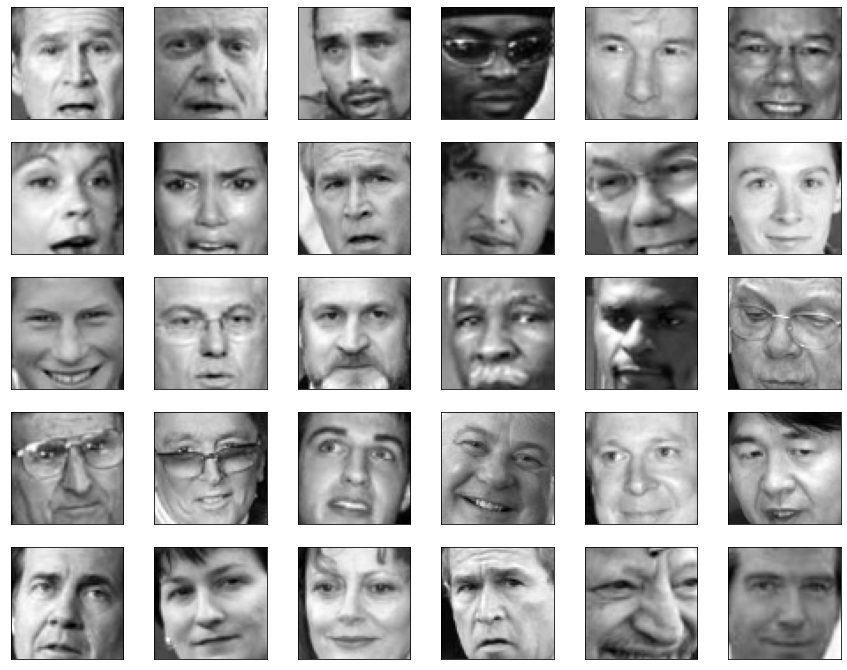

In [ ]:
images = X_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i][:,:,0], cmap='gray')

plt.show()

Imagenes a color originales

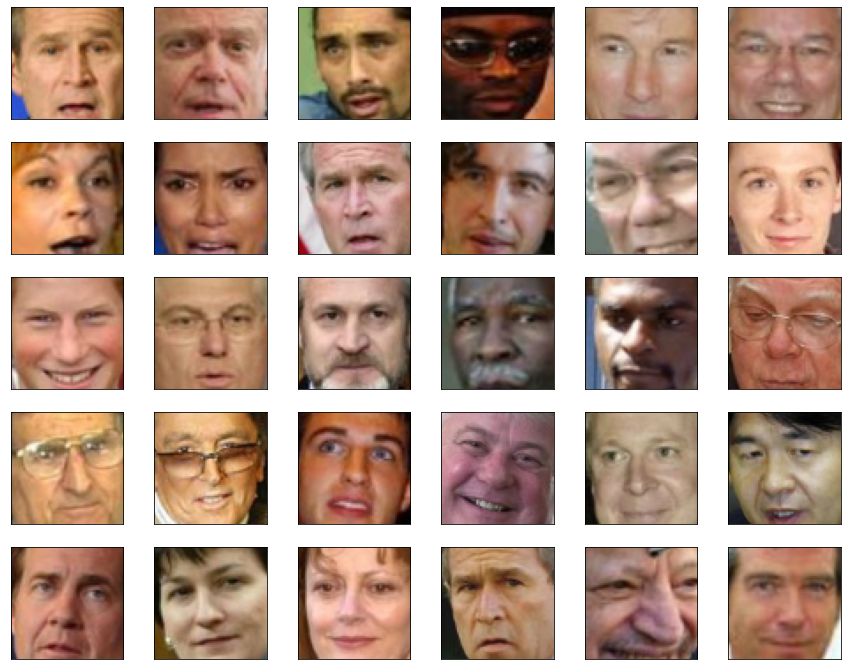

In [ ]:
images = Y_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

Imagenes a color recolorizadas por la red neuronal

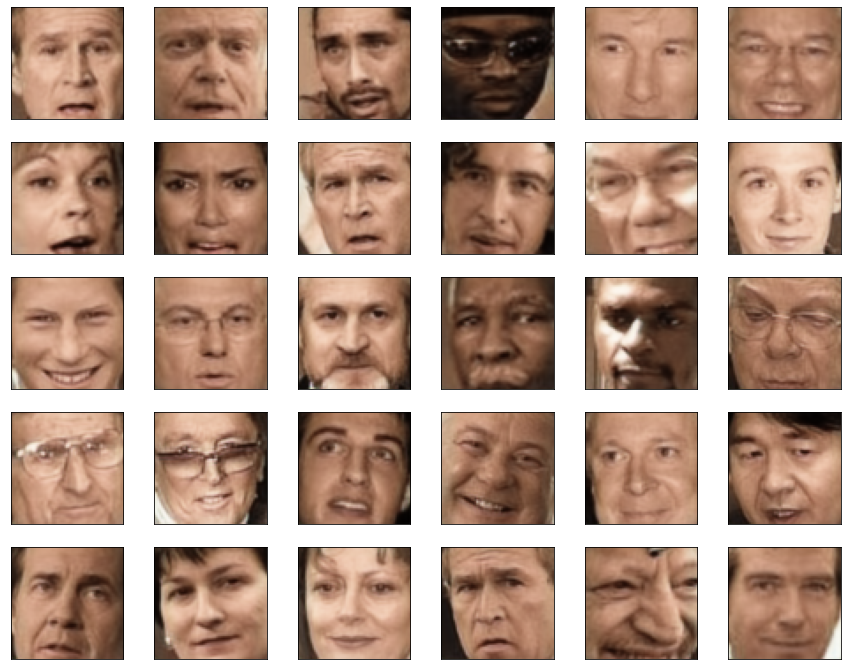

In [ ]:
images = Y_test_colorized

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

Una mejora considerable respecto al primer modelo! Es capaz de reconstruir los patrones espaciales de una mejor manera, aunque respecto al color quedan varias cosas por mejorar.

# MODELO MK03
A more bigger and depth .... model ¿Always is better?

El concepto de mantener el tamaño de la imagen mientras pasa a lo largo del autoencoder aumentando de este modo el numero de filtros y luego volviendo a compactarla, hace que el modelo sea capaz de almacenar los datos espaciales de una mejor manera, logrando de este modo que la imagen reconstruida sea practicamente igual a las imagenes originales.

Respecto al primer modelo se nota que este fue capaz de inferir mejor respecto a la informacion del color de la iamgen pero su reconstruccion de los datos espaciales dejo mucho que desear.

MK03 = MK01 + MK02.1 ??

Parametros

In [ ]:
# Train parameters
epochs = 12
batch_size = 128
kernel_size = 4

#Encoder
input_shape = X_train.shape[1:] # (ancho, alto, canales)
layer_filters_encoder = [64, 128, 256, 512]

#Decoder
channels = Y_train.shape[3]
layer_filters_decoder = layer_filters_encoder[::-1]

NameError: ignored

Encoder

In [ ]:
#Encoder

inputs = Input(shape = input_shape) 

encoder_layers = inputs 

for filters in layer_filters_encoder: 
    encoder_layers = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 1, 
               activation ='relu', 
               padding ='same')(encoder_layers) 

encoder_colorizing = Model(inputs, encoder_layers, name ='encoder_colorizing')

encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

NameError: ignored

Decoder

In [ ]:
#Decoder

input_decoder = Input(shape =(64,64,512), name ='decoder_input') 
decoder_layers =  input_decoder


decoder_layers = Conv2DTranspose(filters = 256, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = 128, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = 64, 
                        kernel_size = kernel_size, 
                        strides = 1, 
                        activation ='relu', 
                        padding ='same')(decoder_layers) 


decoder_layers = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(decoder_layers)

decoder_colorizing = Model(input_decoder, decoder_layers, name ='decoder_colorizing')

decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Autoencoder

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing')

autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model_mk3.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])


In [ ]:
history=autoencoder_colorizing.fit(X_train,
                Y_train,
                validation_data=(X_test, Y_test),
                epochs=1,
                batch_size=batch_size,
                callbacks=callbacks)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
autoencoder_colorizing = load_model('/content/saved_models/colorized_ae_model_mk3.012.h5')

### Prueba del modelo

In [ ]:
Y_test_colorized = autoencoder_colorizing.predict(X_test)

In [ ]:
number_of_images = 30

Imagenes a blanco y negro

In [ ]:
images = X_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i][:,:,0], cmap='gray')

plt.show()

Imagenes a color

In [ ]:
images = Y_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

Imagenes a color recolorizadas por la red neuronal

In [ ]:
images = Y_test_colorized

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

# MODELO MK04

In [ ]:
# Train parameters
epochs = 32
batch_size = 256
kernel_size = 4

Encoder

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        65600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       262272    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)

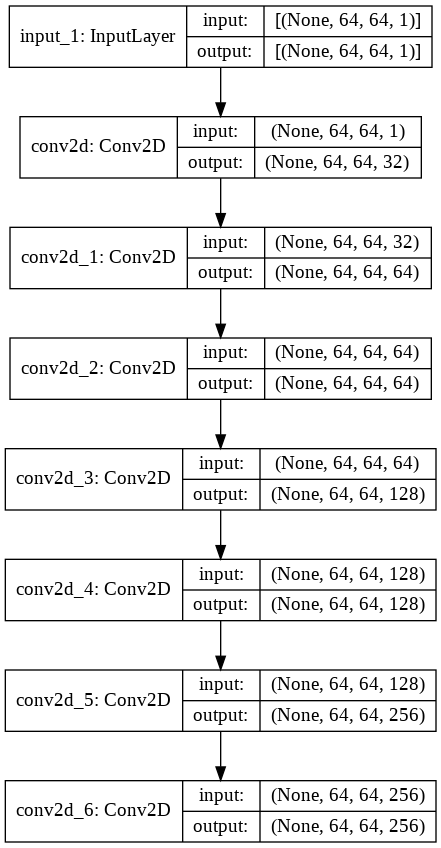

In [ ]:
#Encoder
input_shape = X_train.shape[1:] # (ancho, alto, canales)
layer_filters_encoder = [32, 64, 64, 128, 128, 256, 256]

inputs = Input(shape = input_shape) 

encoder_layers = inputs 

for filters in layer_filters_encoder: 
    encoder_layers = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 1, 
               activation ='relu', 
               padding ='same')(encoder_layers) 

encoder_colorizing = Model(inputs, encoder_layers, name ='encoder_colorizing')

encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

Decoder

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 64, 64, 256)]     0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 64, 64, 128)       524416    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 128)       262272    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 64, 64, 64)        131136    
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 64, 64)        65600     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 64, 64, 32)        32800     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 64, 64, 3)  

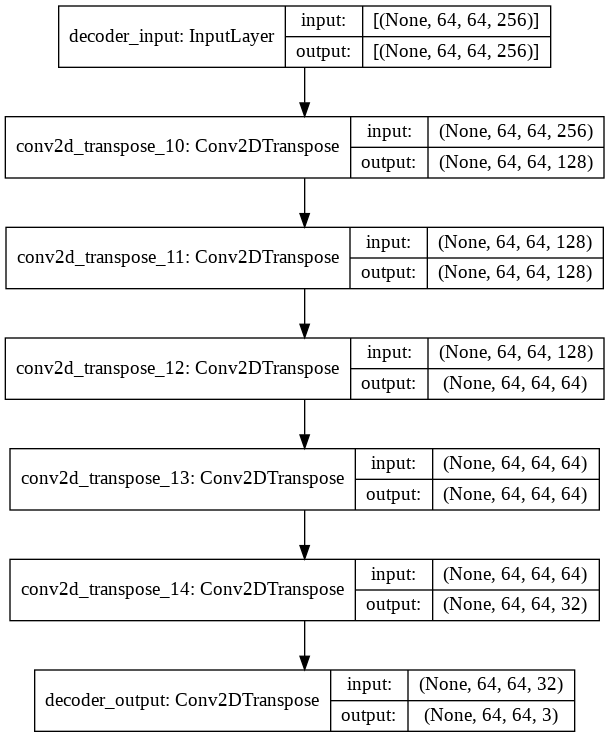

In [ ]:
#Decoder
channels = Y_train.shape[3]
layer_filters_decoder = [128, 128, 64, 64, 32]

input_decoder = Input(shape =(64,64,256), name ='decoder_input') 
decoder_layers =  input_decoder

for filters in layer_filters_decoder:

  decoder_layers = Conv2DTranspose(filters = filters, 
                          kernel_size = kernel_size, 
                          strides = 1, 
                          activation ='relu', 
                          padding ='same')(decoder_layers) 

decoder_layers = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(decoder_layers)

decoder_colorizing = Model(input_decoder, decoder_layers, name ='decoder_colorizing')

decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Autoencoder

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 64, 64, 256)       2065824   
_________________________________________________________________
decoder_colorizing (Function (None, 64, 64, 3)         1017763   
Total params: 3,083,587
Trainable params: 3,083,587
Non-trainable params: 0
_________________________________________________________________


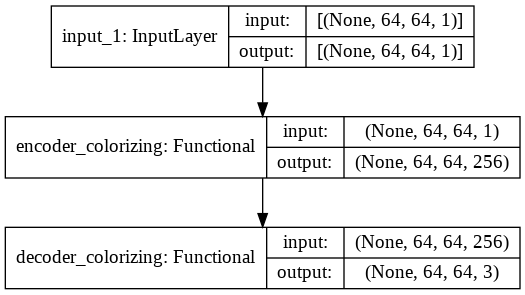

In [ ]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing')

autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

Callbacks

In [ ]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model_mk4.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

Entrenamiento

In [ ]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

In [ ]:
history=autoencoder_colorizing.fit(X_train,
                Y_train,
                validation_data=(X_test, Y_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/32
47/47 [==============================] - 235s 4s/step - loss: 0.0429 - mae: 0.1667 - val_loss: 0.0209 - val_mae: 0.1122

Epoch 00001: val_loss improved from inf to 0.02095, saving model to /content/saved_models/colorized_ae_model_mk4.001.h5
Epoch 2/32
47/47 [==============================] - 159s 3s/step - loss: 0.0156 - mae: 0.0958 - val_loss: 0.0060 - val_mae: 0.0562

Epoch 00002: val_loss improved from 0.02095 to 0.00597, saving model to /content/saved_models/colorized_ae_model_mk4.002.h5
Epoch 3/32
47/47 [==============================] - 161s 3s/step - loss: 0.0056 - mae: 0.0549 - val_loss: 0.0038 - val_mae: 0.0459

Epoch 00003: val_loss improved from 0.00597 to 0.00384, saving model to /content/saved_models/colorized_ae_model_mk4.003.h5
Epoch 4/32
47/47 [==============================] - 161s 3s/step - loss: 0.0036 - mae: 0.0438 - val_loss: 0.0029 - val_mae: 0.0389

Epoch 00004: val_loss improved from 0.00384 to 0.00288, saving model to /content/saved_models/colorized_

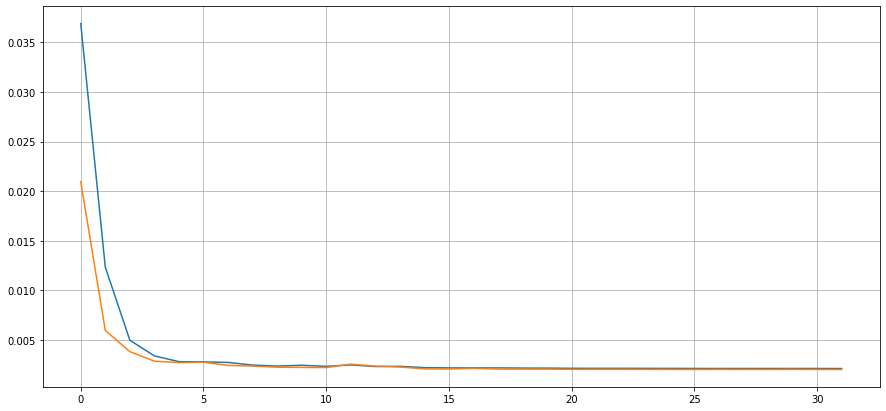

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()


### Prueba del modelo

In [ ]:
Y_test_colorized = autoencoder_colorizing.predict(X_test)

In [ ]:
number_of_images = 30

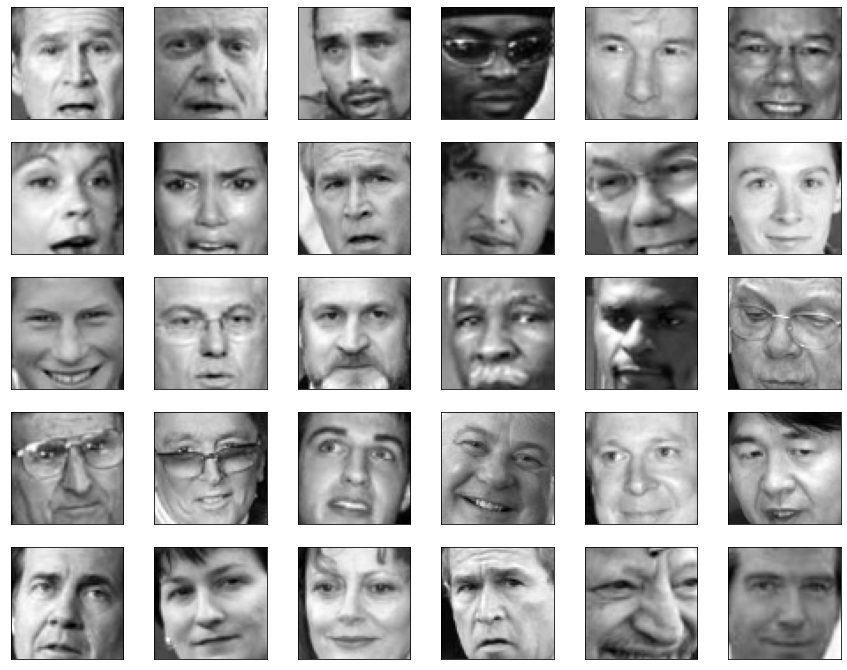

In [ ]:
images = X_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i][:,:,0], cmap='gray')

plt.show()

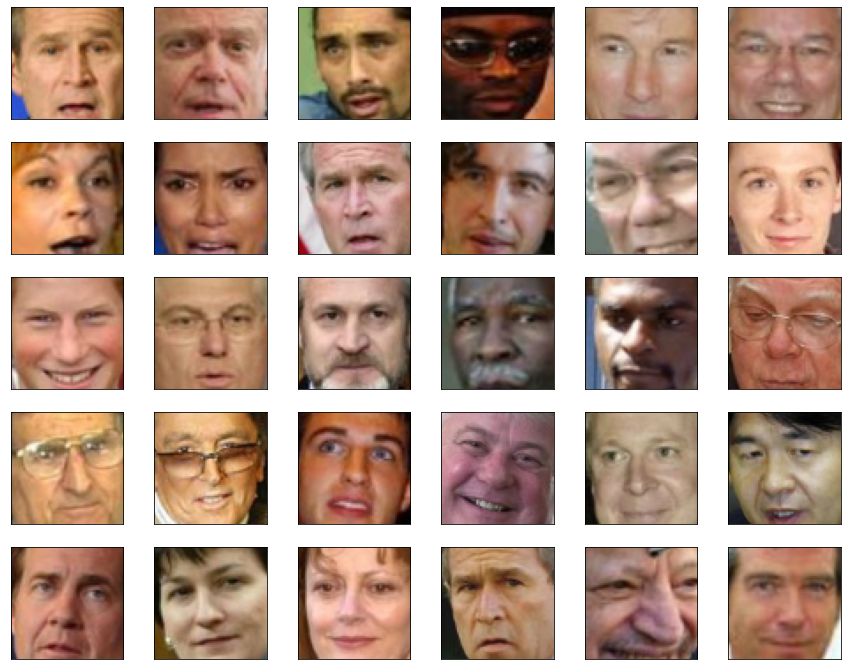

In [ ]:
images = Y_test

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

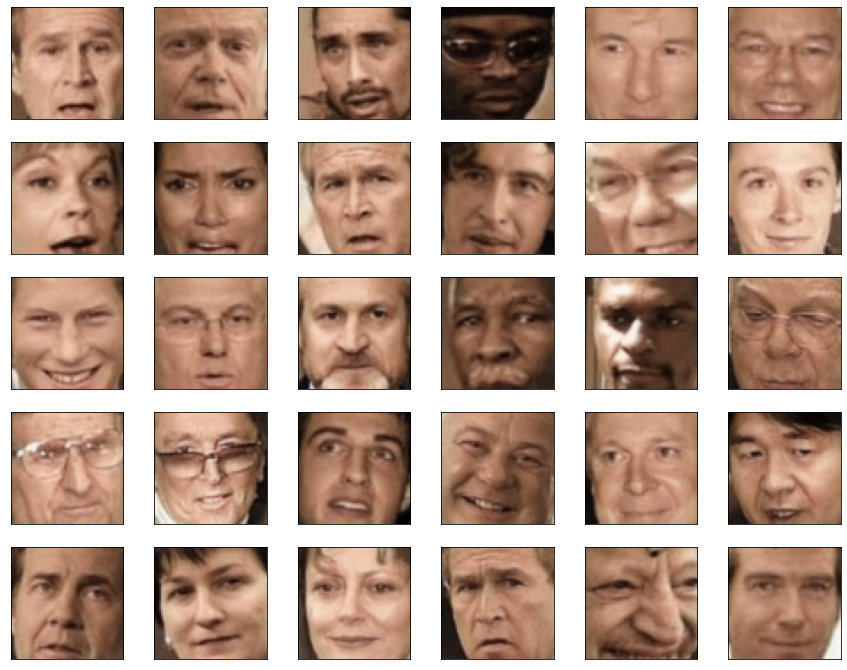

In [ ]:
images = Y_test_colorized

plt.figure(figsize=(15,12))
for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

# TEST CON IMAGEN PROPIA

In [ ]:
from keras.models import load_model
autoencoder_colorizing = load_model('/colorized_ae_model_mk4.029.h5')

In [ ]:
autoencoder_colorizing.summary()

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 64, 64, 256)       2065824   
_________________________________________________________________
decoder_colorizing (Function (None, 64, 64, 3)         1017763   
Total params: 3,083,587
Trainable params: 3,083,587
Non-trainable params: 0
_________________________________________________________________


In [ ]:
imagen_final = cv2.imread(cv2.samples.findFile("drive/MyDrive/DIPLOMADO INTELIGENCIA ARTIFICIAL/TAREAS/9. RETOS/1. Recolorizacion de imagenes de rostros/TEST.jpg"))

In [ ]:
imagen_final = np.expand_dims(imagen_final[:,:,0], axis=2)

In [ ]:
imagen_final = imagen_final.astype('float32') 
imagen_final = imagen_final / 255
imagen_final = imagen_final.reshape((1, 64,64,1))

In [ ]:
imagen_final_colorizada = autoencoder_colorizing.predict(imagen_final)

Imagen original

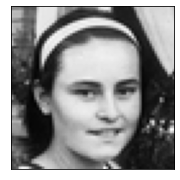

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(imagen_final[0,:,:,0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)

Imagen colorizada con deep learning

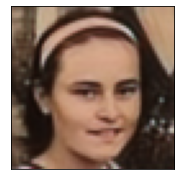

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(imagen_final_colorizada[0,:,:,:])
plt.xticks([])
plt.yticks([])
plt.grid(False)